# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [4]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [14]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [17]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3841.752443,1.0001,-131.886217,1656.82,1524.933783
OMUSDT,526.319895,1783.941186,0.4644,0.000000,1257.62,1257.620000
BTCUSDT,601.021649,882.007930,0.2296,3.537078,280.99,284.527078
JASMYUSDT,387.458505,405.534987,0.1056,0.000000,18.08,18.080000
SOLUSDT,281.200518,381.042101,0.0992,0.000000,99.84,99.840000
ETHUSDT,250.747339,230.838043,0.0601,0.000000,-19.91,-19.910000
TRXUSDT,76.868953,116.396126,0.0303,-10.723889,39.53,28.806111
BBUSDT,60.176053,40.779192,0.0106,-39.733101,-19.40,-59.133101
BNBUSDT,1.142121,1.212874,0.0003,-10.606040,0.07,-10.536040
PEPEUSDT,0.000004,0.000004,0.0000,-38.521986,0.00,-38.521986


In [21]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [22]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [23]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [24]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [26]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [27]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [28]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [29]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6468\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [30]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-01-11    -54.263495
2025-01-12    -71.018396
2025-01-13     -7.492273
2025-01-14    -25.751420
2025-01-15    217.398651
Name: Total, Length: 115, dtype: float64

In [31]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-01-11    1461.693143
2025-01-12    1390.674748
2025-01-13    1383.182474
2025-01-14    1357.431054
2025-01-15    1574.829706
Name: Total, Length: 115, dtype: float64

In [32]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [33]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [34]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [35]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_6468\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [36]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [37]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [38]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

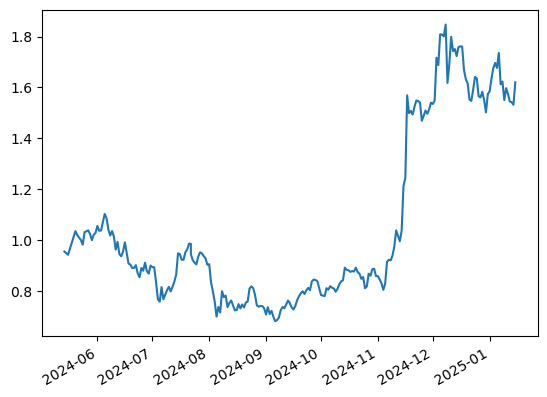

In [39]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [41]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [44]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [45]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [48]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3826
XRPUSDT,0.2117
BNBUSDT,0.2066
SUIUSDT,0.1084
PEPEUSDT,0.0793
AAVEUSDT,0.0090
RAYUSDT,0.0021
ADAUSDT,0.0004
BONKUSDT,0.0000
RUNEUSDT,0.0000


In [49]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.361245
BTCUSDT,0.300000
XRPUSDT,0.153588
SUIUSDT,0.087844
BNBUSDT,0.053614
PEPEUSDT,0.043709


### Current results

In [51]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [52]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.453984
OMUSDT,0.407228
TRXUSDT,0.138788


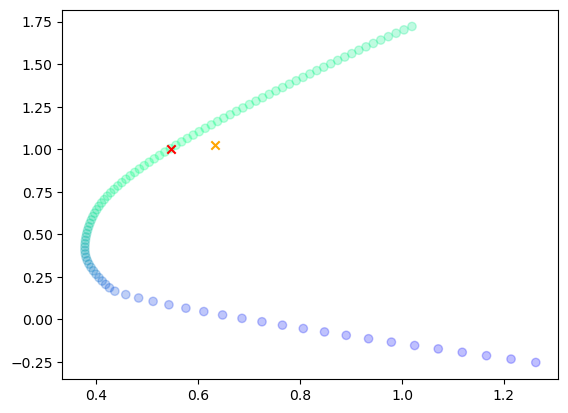

In [53]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [55]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1783.941186,0.464356,0.407228,0.057128
BTCUSDT,882.007930,0.229585,0.453984,-0.224399
JASMYUSDT,405.534987,0.105560,0.000000,0.000000
SOLUSDT,381.042101,0.099184,0.000000,0.000000
ETHUSDT,230.838043,0.060087,0.000000,0.000000
TRXUSDT,116.396126,0.030298,0.138788,-0.108490
BBUSDT,40.779192,0.010615,0.000000,0.000000
BNBUSDT,1.212874,0.000316,0.000000,0.000000
PEPEUSDT,0.000004,0.000000,0.000000,0.000000


In [56]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1783.941186,0.464356,0.361245,0.103111
BTCUSDT,882.007930,0.229585,0.300000,-0.070415
JASMYUSDT,405.534987,0.105560,0.000000,0.000000
SOLUSDT,381.042101,0.099184,0.000000,0.000000
ETHUSDT,230.838043,0.060087,0.000000,0.000000
TRXUSDT,116.396126,0.030298,0.000000,0.000000
BBUSDT,40.779192,0.010615,0.000000,0.000000
BNBUSDT,1.212874,0.000316,0.053614,-0.053298
PEPEUSDT,0.000004,0.000000,0.043709,-0.043709
XRPUSDT,0.000000,0.000000,0.153588,0.000000


# Risk Reward Analysis

In [58]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [59]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

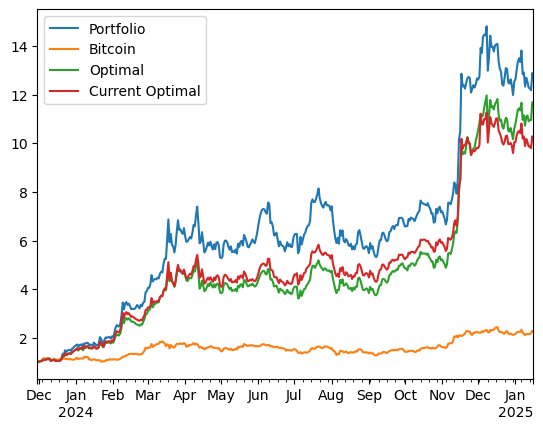

In [60]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [61]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

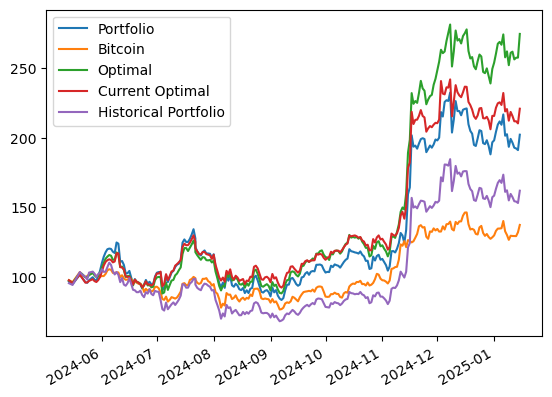

In [62]:
((1+current_perf).cumprod()*100).plot()

In [63]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-01-06,216.840028,140.295083,274.330075,232.241814,173.552243
2025-01-07,201.567270,132.854249,257.863741,219.009487,161.238715
2025-01-08,202.626722,130.233268,262.151210,220.693369,162.328047
2025-01-09,193.569093,126.750994,252.238867,212.346116,155.071619
2025-01-10,199.275861,129.693358,261.101072,218.636169,159.729385
2025-01-11,196.558253,129.520567,261.933416,215.690148,157.464627
2025-01-12,192.934057,129.445338,256.389575,211.919342,154.493622
2025-01-13,192.404834,129.433070,257.611060,211.945325,154.218040
2025-01-14,191.231937,132.175978,257.683117,210.421833,153.215122
2025-01-15,202.293916,137.457449,274.694643,220.962258,162.042883


## Volatilities

In [65]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.610076
 dtype: float64,
 0.610793089237923)

In [66]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.632691
 dtype: float64,
 0.6326912810835363)

In [67]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.711561
Bitcoin            0.430238
Optimal            0.610793
Current Optimal    0.620592
dtype: float64

In [68]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.44391842315235597

## Risk Contribution

In [70]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.086491,0.053614,0.006963,0.019508,0.001713,0.017796
BTCUSDT,0.381210,0.300000,0.033854,0.139375,0.044655,0.094720
OMUSDT,17.777827,0.361245,0.901461,0.648663,0.537951,0.110712
PEPEUSDT,0.177144,0.043709,0.010976,0.042481,0.007928,0.034553
SUIUSDT,0.266751,0.087844,0.017622,0.062772,0.018686,0.044085
XRPUSDT,0.432429,0.153588,0.029123,0.087201,0.028942,0.058260


In [71]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.979724,0.407228,0.616981,0.698304,0.578594,0.119710
BTCUSDT,0.209040,0.453984,0.294944,0.210948,0.114741,0.096206
TRXUSDT,0.059201,0.138788,0.088075,0.090748,0.045992,0.044755


In [72]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.106685,0.46,0.700996,0.674142,0.549412,0.124731
BTCUSDT,0.105905,0.23,0.150297,0.094012,0.021917,0.072095
JASMYUSDT,-0.000219,0.11,0.049120,0.109381,0.035212,0.074169
SOLUSDT,0.017546,0.10,0.052594,0.070963,0.010459,0.060504
ETHUSDT,-0.001380,0.06,0.026229,0.028870,0.002672,0.026198
TRXUSDT,0.012797,0.03,0.019149,0.012335,0.001599,0.010736
BBUSDT,-0.006392,0.01,0.001614,0.010297,0.000398,0.009899


# Value At Risk

## Historical

### Optimal Weights

In [76]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05035962161754799, -0.07354243562918324)

### Current Weights

In [78]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04826403007897699, -0.0724979206159301)

In [79]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [80]:
var=historical_var.iloc[row]
var

OMUSDT      -0.034123
BTCUSDT     -0.002147
JASMYUSDT   -0.006109
SOLUSDT     -0.003077
ETHUSDT     -0.001657
TRXUSDT     -0.000430
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048788
Name: 2024-07-22 00:00:00, dtype: float64

In [81]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.041707
BTCUSDT     -0.008374
JASMYUSDT   -0.010488
SOLUSDT     -0.006872
ETHUSDT     -0.003041
TRXUSDT     -0.001039
BBUSDT      -0.000977
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072498
dtype: float64

## Parametric

### Optimal Weights

In [84]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06328796058472815, -0.08111766731762458)

### Current Weights

In [86]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06555696448608392, -0.08402590297432837)

## Multivariate

### Optimal Weights

In [89]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.056843375816240424, -0.07361910190935853)

### Current Weights

In [91]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0613948439458941, -0.0773365382426831)

In [92]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.044002
BTCUSDT     -0.004675
JASMYUSDT   -0.006232
SOLUSDT     -0.003937
ETHUSDT     -0.001357
TRXUSDT     -0.000562
BBUSDT      -0.000587
Portfolio   -0.061353
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [96]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054954378899608705, -0.07204206418108128)

### Current Weights

In [98]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061826598832090185, -0.07799432519383649)

In [99]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039692
BTCUSDT     -0.006063
JASMYUSDT   -0.007617
SOLUSDT     -0.004534
ETHUSDT     -0.001987
TRXUSDT     -0.000965
BBUSDT      -0.000731
Portfolio   -0.061589
dtype: float64

## Student Copula

### Optimal Weights

In [102]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05600192490943781, -0.07207844693572756)

### Current Weights

In [104]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061731936277608625, -0.07952684152794229)

In [105]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.043875
BTCUSDT     -0.005467
JASMYUSDT   -0.006206
SOLUSDT     -0.004268
ETHUSDT     -0.001685
TRXUSDT     -0.000706
BBUSDT      -0.000570
Portfolio   -0.062777
dtype: float64

## Gumbel Copula

### Optimal Weights

In [108]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10305271223826702, -0.14502676230026862)

### Current Weights

In [110]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10985546077373205, -0.1542493834797501)

In [111]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.097702
BTCUSDT     -0.001485
JASMYUSDT   -0.006342
SOLUSDT     -0.002787
ETHUSDT      0.000052
TRXUSDT     -0.000250
BBUSDT      -0.000049
Portfolio   -0.108563
dtype: float64

## Monte Carlo

### Optimal

In [114]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [115]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06506455382786337, -0.08023781698062334)

### Current Weights

In [117]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06701582680901358, -0.08417323699889166)

In [118]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.043024
BTCUSDT     -0.006435
JASMYUSDT   -0.008919
SOLUSDT     -0.005111
ETHUSDT     -0.001961
TRXUSDT     -0.000757
BBUSDT      -0.000791
Portfolio   -0.066999
dtype: float64

## VaR Violation

In [120]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.053138,-0.090428,-0.077000,-0.020401
2024-01-15,-0.053138,-0.090484,-0.074643,0.021582
2024-01-16,-0.053138,-0.089940,-0.073305,0.038321
2024-01-17,-0.053138,-0.091766,-0.076942,-0.027266
2024-01-18,-0.053138,-0.094558,-0.081529,-0.038709
...,...,...,...,...
2025-01-12,-0.058805,-0.061584,-0.062380,-0.021165
2025-01-13,-0.058805,-0.061472,-0.063798,0.004764
2025-01-14,-0.058805,-0.060794,-0.063942,0.000280
2025-01-15,-0.058805,-0.067175,-0.066461,0.066017


In [121]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035213,-0.084231,-0.079446,-0.016801
2024-05-29,-0.035213,-0.081646,-0.072643,-0.008716
2024-05-30,-0.035213,-0.071233,-0.069844,0.034481
2024-05-31,-0.035213,-0.072257,-0.062694,0.037930
2024-06-01,-0.035213,-0.075749,-0.066273,0.052879
...,...,...,...,...
2025-01-12,-0.066831,-0.076212,-0.076110,-0.018438
2025-01-13,-0.066831,-0.075226,-0.074200,-0.002743
2025-01-14,-0.066831,-0.072675,-0.069823,-0.006096
2025-01-15,-0.066831,-0.075727,-0.075527,0.057846


<Axes: >

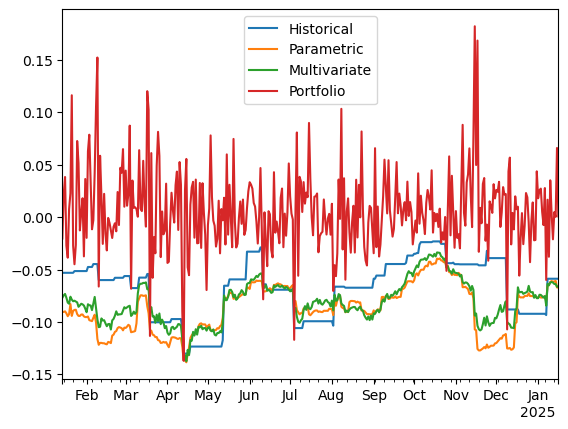

In [122]:
var_data.plot()

<Axes: >

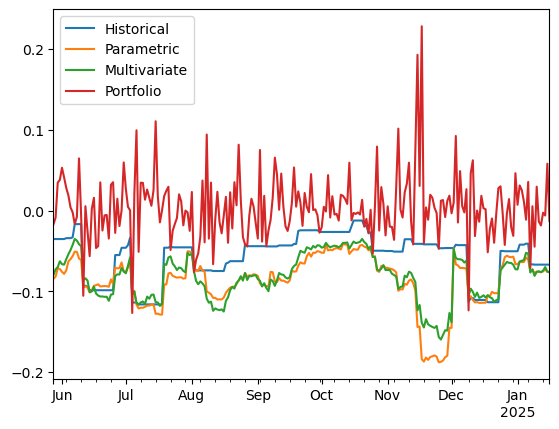

In [123]:
current_var_data.plot()

In [124]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02439,0.01355,0.01626
Kupiec Stat,6.231375,14.353313,11.857367
P-value,0.012551,0.000152,0.000574


In [125]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.059829,0.017094,0.017094
Kupiec Stat,0.448997,7.077329,7.077329
P-value,0.502812,0.007807,0.007807


# Principal Component Analysis

## Historical PCA

In [128]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78085785, 0.06984003, 0.05509543, 0.05193209, 0.0422746 ])

In [129]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015459
ADAUSDT     0.015821
ALGOUSDT    0.017984
APTUSDT     0.016176
ARBUSDT     0.017195
              ...   
WBTCUSDT    0.009176
WLDUSDT     0.022015
XLMUSDT     0.012906
XRPUSDT     0.011127
XTZUSDT     0.016252
Name: PC1, Length: 62, dtype: float64

<Axes: >

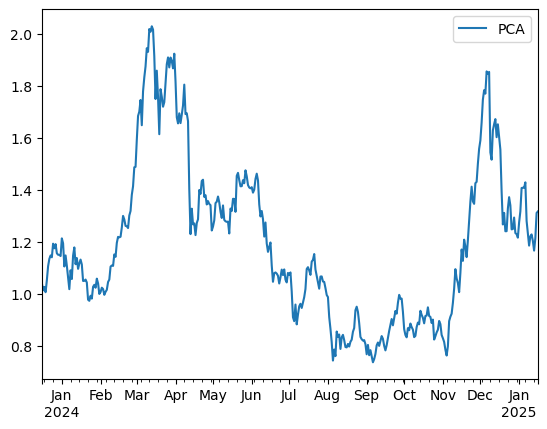

In [130]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

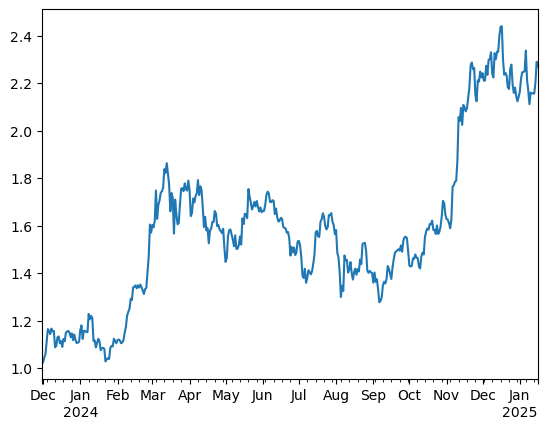

In [131]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [132]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.422521
ETHUSDT      0.434463
WBETHUSDT    0.434552
ETCUSDT      0.452891
               ...   
FLOKIUSDT    1.134025
WLDUSDT      1.141634
BONKUSDT     1.145995
PEPEUSDT     1.195637
OMUSDT       1.557397
Length: 63, dtype: float64

<Axes: >

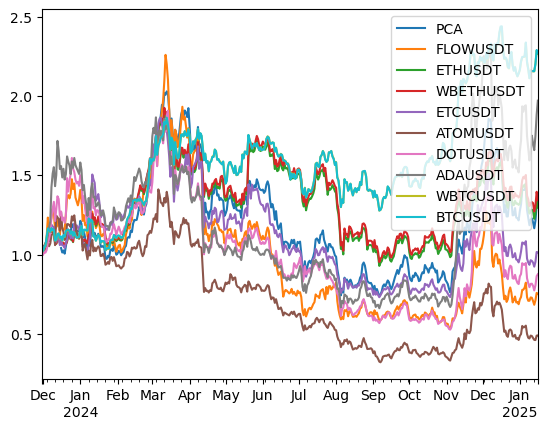

In [133]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

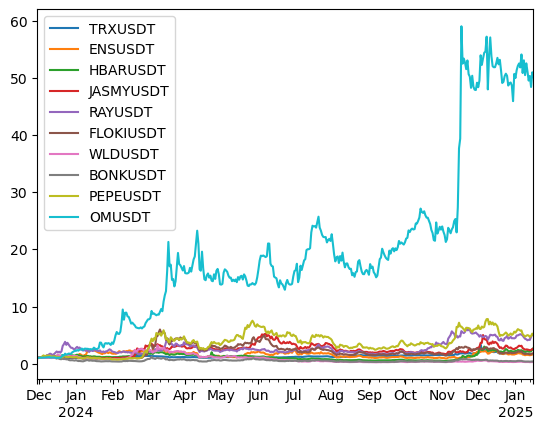

In [134]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [136]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.55376033, 0.14605343, 0.12701065, 0.10006077, 0.07311482])

In [137]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.093879
BTCUSDT      0.061450
JASMYUSDT    0.169464
SOLUSDT      0.103157
ETHUSDT      0.084862
TRXUSDT      0.053411
BBUSDT       0.211296
BNBUSDT      0.066507
PEPEUSDT     0.155974
Name: PC1, dtype: float64

<Axes: >

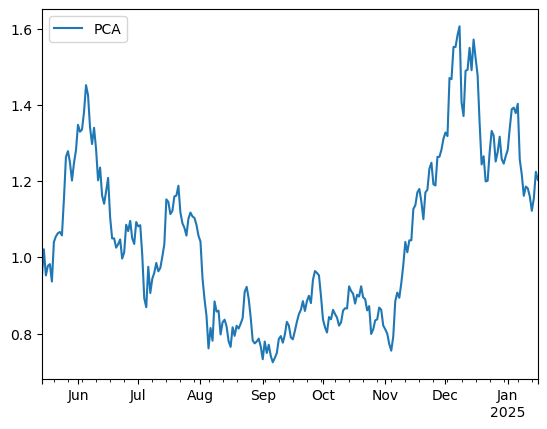

In [138]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

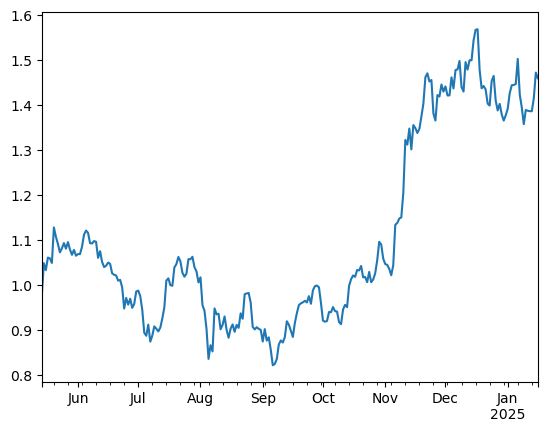

In [139]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [140]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.407350
ETHUSDT      0.416194
BNBUSDT      0.439039
BTCUSDT      0.453486
JASMYUSDT    0.663568
PEPEUSDT     0.726584
BBUSDT       0.757587
TRXUSDT      0.892130
OMUSDT       0.919146
dtype: float64

<Axes: >

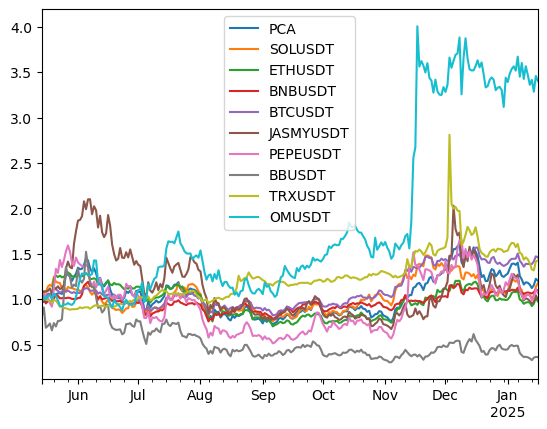

In [141]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [143]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.892668
BBUSDT       1.564536
JASMYUSDT    1.295650
SOLUSDT      1.159048
BTCUSDT      1.000000
ETHUSDT      0.969874
OMUSDT       0.881722
BNBUSDT      0.661327
TRXUSDT      0.306448
Name: BTCUSDT, dtype: float64

In [144]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.997354
JASMYUSDT    1.873712
PEPEUSDT     1.811874
SOLUSDT      1.547206
ETHUSDT      1.332555
TRXUSDT      1.136519
BTCUSDT      1.000000
OMUSDT       0.988836
BNBUSDT      0.626197
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [146]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [147]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
SOLUSDT,0.302819
JASMYUSDT,0.291485
BNBUSDT,0.176867
PEPEUSDT,0.144487
ETHUSDT,0.118943
BBUSDT,0.078078
TRXUSDT,0.042594
BTCUSDT,-0.028758
OMUSDT,-0.099345


### Regression to PCA

In [149]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.191406424311818

In [150]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.281309
BNBUSDT      1.162930
ETHUSDT      1.009173
PCA          1.000000
SOLUSDT      0.820645
JASMYUSDT    0.436340
PEPEUSDT     0.397876
BBUSDT       0.367879
OMUSDT       0.240044
TRXUSDT      0.233973
dtype: float64

In [151]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      2.311832
BTCUSDT      1.626145
ETHUSDT      1.134083
TRXUSDT      1.113261
PCA          1.000000
SOLUSDT      0.911890
PEPEUSDT     0.843715
JASMYUSDT    0.744600
BBUSDT       0.676312
OMUSDT       0.666043
dtype: float64

### Correlation Matrix

<Axes: >

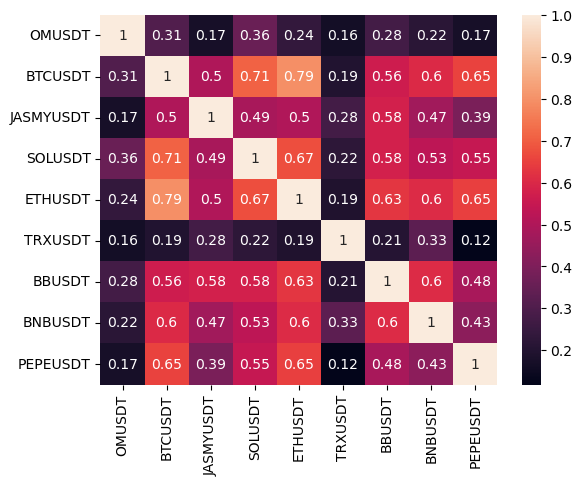

In [153]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

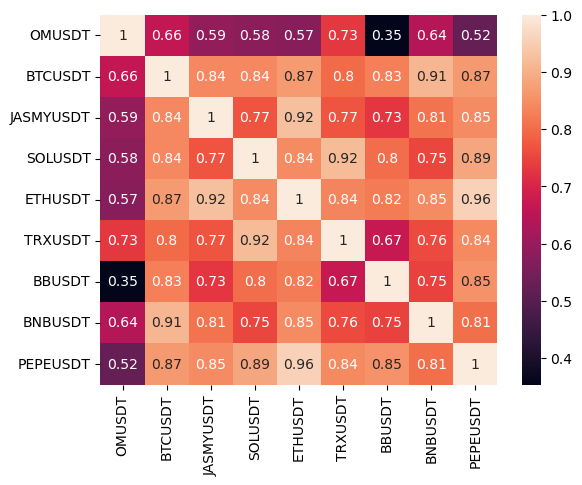

In [154]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [156]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [157]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-06-10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.06564,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-07-10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.958310,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-08-09,0.136564,0.014227,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.814631,0.0
2024-09-08,0.125668,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.685665,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-08,0.000000,0.000000,0.0,0.019522,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046604,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-07,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-07,0.000000,0.000014,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.014780,0.0
2025-01-06,0.216207,0.021714,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-01-16,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.126386,0.0
